## Results for lateralization paper

This notebook contains the results for the lateralization paper. It is organized as follows:
- Section 1: show the original simulated LFPs. Limited cycling?
- Section 2: For $\gamma$ band: spikes count, burst, average amplitude, and power; For $\theta$ band: average amplitude and power. 
- Section 3: The phase information for $\gamma$ band and $\theta$ band (polar graph). The phase locking value between left and right hemispheres; The phase-amplitude coupling for $\gamma$ band and $\theta$ band.
- Section 4: The distribution of structural connections in limbic subnetwork; Homotopic vs Heterotopic connections;
- Section 5: Meta-connectivity.


In [10]:
import sys
sys.path.append('/Users/yilewang/workspaces/')

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from os.path import join as pjoin
from scipy import signal
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from tvbtools.tools import burst_detection
from statannotations.Annotator import Annotator

In [12]:
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R',
              'pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L',
              'PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R',
              'mTEMp-L','mTEMp-R']

# conduct signal downsample first
def down_sample(data, fs, new_fs):
    new_data = signal.decimate(data, int(fs/new_fs), axis=0, zero_phase=True)
    return new_data

# generate a sos bandpass filter function
def butter_bandpass(lowcut, highcut, fs, data, order=5):
    nyq = 0.5 * fs # nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], analog=False, btype="band", output="sos")
    filtered_signal = signal.sosfiltfilt(sos, data)
    return filtered_signal


def before_after_graph(befores, afters, ax, ylim=[-0.5, 35]):
    # plotting the points
    ax.scatter(np.zeros(len(befores)), befores, s=1, color='k')
    ax.scatter(np.ones(len(afters)), afters, s=1, color='k')
    # plotting the lines
    for i in range(len(befores)):
        ax.plot( [0,1], [befores[i], afters[i]], alpha=0.2, color='k')
    # hide the frame
    sns.despine(top=True, right=True, left=True)
    # ax.set_xticks([0.25, 0.75], ['gc', 'gc_K21'])
    ax.set_xticks([])
    # find max of befores and afters
    ax.set_ylim(ylim)

def spikes_bursts(signal, fs, caseid, group):
    subj_df = pd.DataFrame()
    # get spikes data
    spikes_table = burst_detection.generate_spikes_analyses(signal[8192:], fs, thresh_prominence=0.5)

    ### AVERAGE SPIKE FEATURES
    # get the average spike amplitude
    avg_spike_amplitude = np.mean(spikes_table['spike_amplitude'])


    # get the average spike frequency
    avg_spike_frequency = np.mean(spikes_table['inst_freq'][1:])

    
    # get the average spike width
    avg_spike_width_xi = np.mean(spikes_table['width'])

    # get the average isi_s
    avg_isi_s = np.mean(spikes_table['isi_s'])

    # get the average rise_half_ms
    avg_rise_half_ms = np.mean(spikes_table['rise_half_ms'])

    # get the average decay_half_ms
    avg_decay_half_ms = np.mean(spikes_table['decay_half_ms'])


    # get burst features
    burst_table_xi = burst_detection.bursts_detection(spikes_table)
    # burst analyses
    burst_xi_stats = burst_detection.generate_bursts_stats(caseid, burst_table_xi, spikes_table)

    burst_xi_stats['group'] = group
    burst_xi_stats['Mean Spike Amplitude'] = avg_spike_amplitude
    burst_xi_stats['Mean Spike Frequency'] = avg_spike_frequency
    burst_xi_stats['Mean Spike Width'] = avg_spike_width_xi
    burst_xi_stats['Mean ISI (sec)'] = avg_isi_s
    burst_xi_stats['Mean Rise Half (ms)'] = avg_rise_half_ms
    burst_xi_stats['Mean Decay Half (ms)'] = avg_decay_half_ms
    subj_df = pd.concat([subj_df, burst_xi_stats])
    # replace all nan to 0
    subj_df.fillna(0, inplace=True)
    return subj_df
        

### Section 0: loading data

In [13]:
# Load the data
data_path = '/Users/yilewang/Documents/simulated_LFP_Gc_3modes'
# Load the info
table_path = '/Users/yilewang/workspaces/data4project/mega_table.xlsx'
table = pd.read_excel(table_path, sheet_name='hodgepodge', skiprows=1)
groups = table.group
caseids = table.caseid
Gc = table.Gc

### Section 1: Original LFPs

In [60]:
# filter the data
fs = 81920
subj_df_xi = pd.DataFrame()
subj_df_alpha = pd.DataFrame()
for caseid, group, gc in zip(caseids, groups, Gc):
    # Load the data
    data = np.load(pjoin(data_path, str(group), f'{caseid}_{gc}.npy'))
    xi = np.mean(data[:,0,:,:], axis=2)
    alpha = np.mean(data[:,1,:,:], axis=2)
    
    # figure = plt.figure(figsize=(10, 5))
    # ax1 = figure.add_subplot(121)
    # ax2 = figure.add_subplot(122)
    # ax1.plot(xi[:81920, :],alpha=0.5)
    # ax2.plot(alpha[:81920, :],alpha=0.5)
    # plt.title(f'{group} {caseid} {gc}')
    # plt.show()

    # apply the bandpass filter
    pCNG_L_xi_filtered = butter_bandpass(3, 10, fs, xi[:,4])
    pCNG_L_alpha_filtered = butter_bandpass(3, 10, fs, alpha[:,4])
    
    for i in range(len(node_names)):
        xi_node = spikes_bursts(xi[:,i], fs, caseid, group)
        xi_node['node'] = node_names[i]
        alpha_node = spikes_bursts(alpha[:,i], fs, caseid, group)
        alpha_node['node'] = node_names[i]
        subj_df_xi = pd.concat([subj_df_xi, xi_node])
        subj_df_alpha = pd.concat([subj_df_alpha, alpha_node])

    # apply spike_burst function
    # Plot the LFP
    # plt.figure(figsize=(10, 5))
    # plt.plot(xi[:81920,4],label='xi_left')    
    # plt.plot(alpha[:81920,4],label='alpha_left')
    # # plt.plot(xi[:,5],label='xi_right')
    # # plt.plot(alpha[:,5],label='alpha_right')
    # plt.legend()
    # plt.title(f'{caseid} {gc}')
    # plt.show()

No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes de

In [15]:
cols = list(subj_df_xi.columns)
cols = [cols[5]] + cols[0:5] + cols[6:]
subj_df_xi = subj_df_xi[cols]
subj_df_alpha = subj_df_alpha[cols]

#### Section 1.1: LFPs, pCNG-L vs pCNG-R

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_pCNG-L vs. NC_pCNG-R: Mann-Whitney-Wilcoxon test two-sided, P_val:3.183e-04 U_stat=3.200e+01
SNC_pCNG-L vs. SNC_pCNG-R: Mann-Whitney-Wilcoxon test two-sided, P_val:5.740e-03 U_stat=1.300e+01
MCI_pCNG-L vs. MCI_pCNG-R: Mann-Whitney-Wilcoxon test two-sided, P_val:7.876e-08 U_stat=1.560e+02
AD_pCNG-L vs. AD_pCNG-R: Mann-Whitney-Wilcoxon test two-sided, P_val:2.109e-04 U_stat=1.200e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_pCNG-L vs. NC_pCNG-R: Mann-Whitne

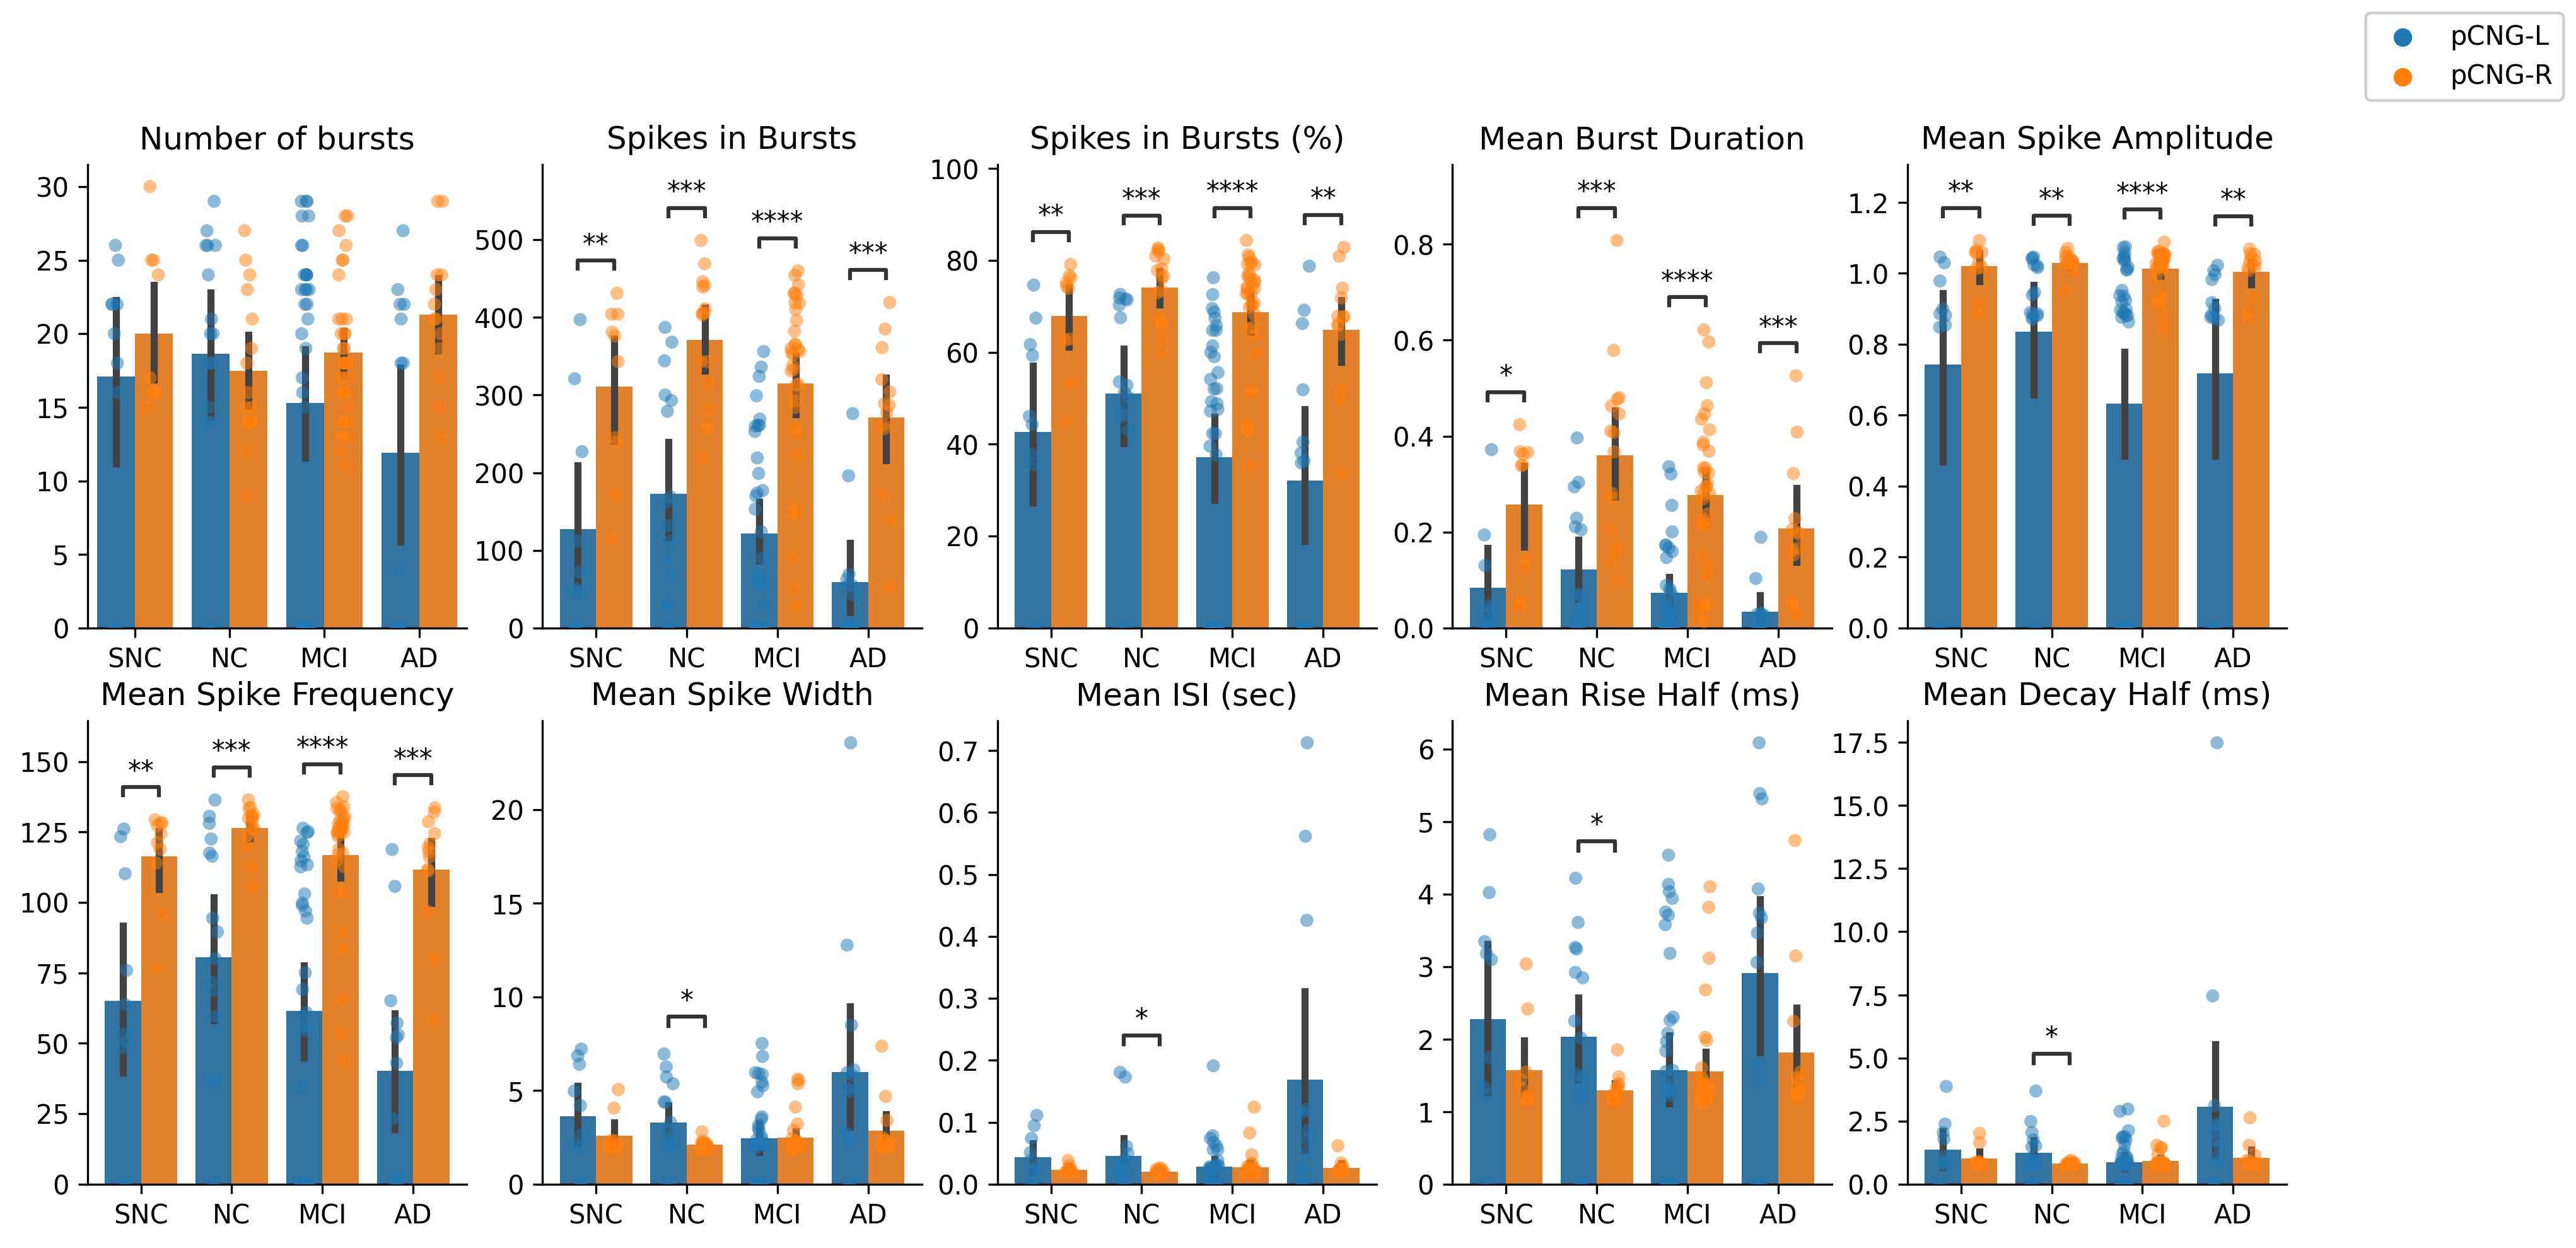

In [54]:
# plot the comparison between xi and alpha
figure = plt.figure(figsize=(15, 7), dpi=300)

# calculate the differences between xi and alpha in all columns

for i in subj_df_alpha.columns[2:12]:
    ax = figure.add_subplot(2,5, list(subj_df_alpha.columns[2:12]).index(i)+1)
    sns.barplot(x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]['group'], 
                y=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])][i], 
                hue=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]["node"],
                 ax=ax, errorbar='ci')
    sns.stripplot(x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]['group'], 
                y=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])][i], 
                hue=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]["node"],
                 ax=ax, dodge=True, alpha=0.5, jitter=True)
    # no legend
    ax.get_legend().remove()
    # hide top and right frame
    sns.despine(top=True, right=True)
    # sns.barplot(x='group', y=i, data=subj_df_alpha, ax=ax)
    ax.set_title(i)
    # hide ax xlabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    handles, labels = figure.gca().get_legend_handles_labels()
    figure.legend(handles[:2], labels[:2], loc='upper right')
    annot = Annotator(ax, [
            (("SNC", "pCNG-L"), ("SNC", "pCNG-R")),(("NC", "pCNG-L"), ("NC", "pCNG-R")), (("MCI","pCNG-L"), ("MCI", "pCNG-R")), (("AD", "pCNG-L"), ("AD", "pCNG-R"))],
            x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]['group'],
            y=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])][i],
            hue=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]["node"])
    annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True)
    annot.apply_and_annotate()

#### Section 1.2: LFPs, pCNG-R - pCNG-L

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.0

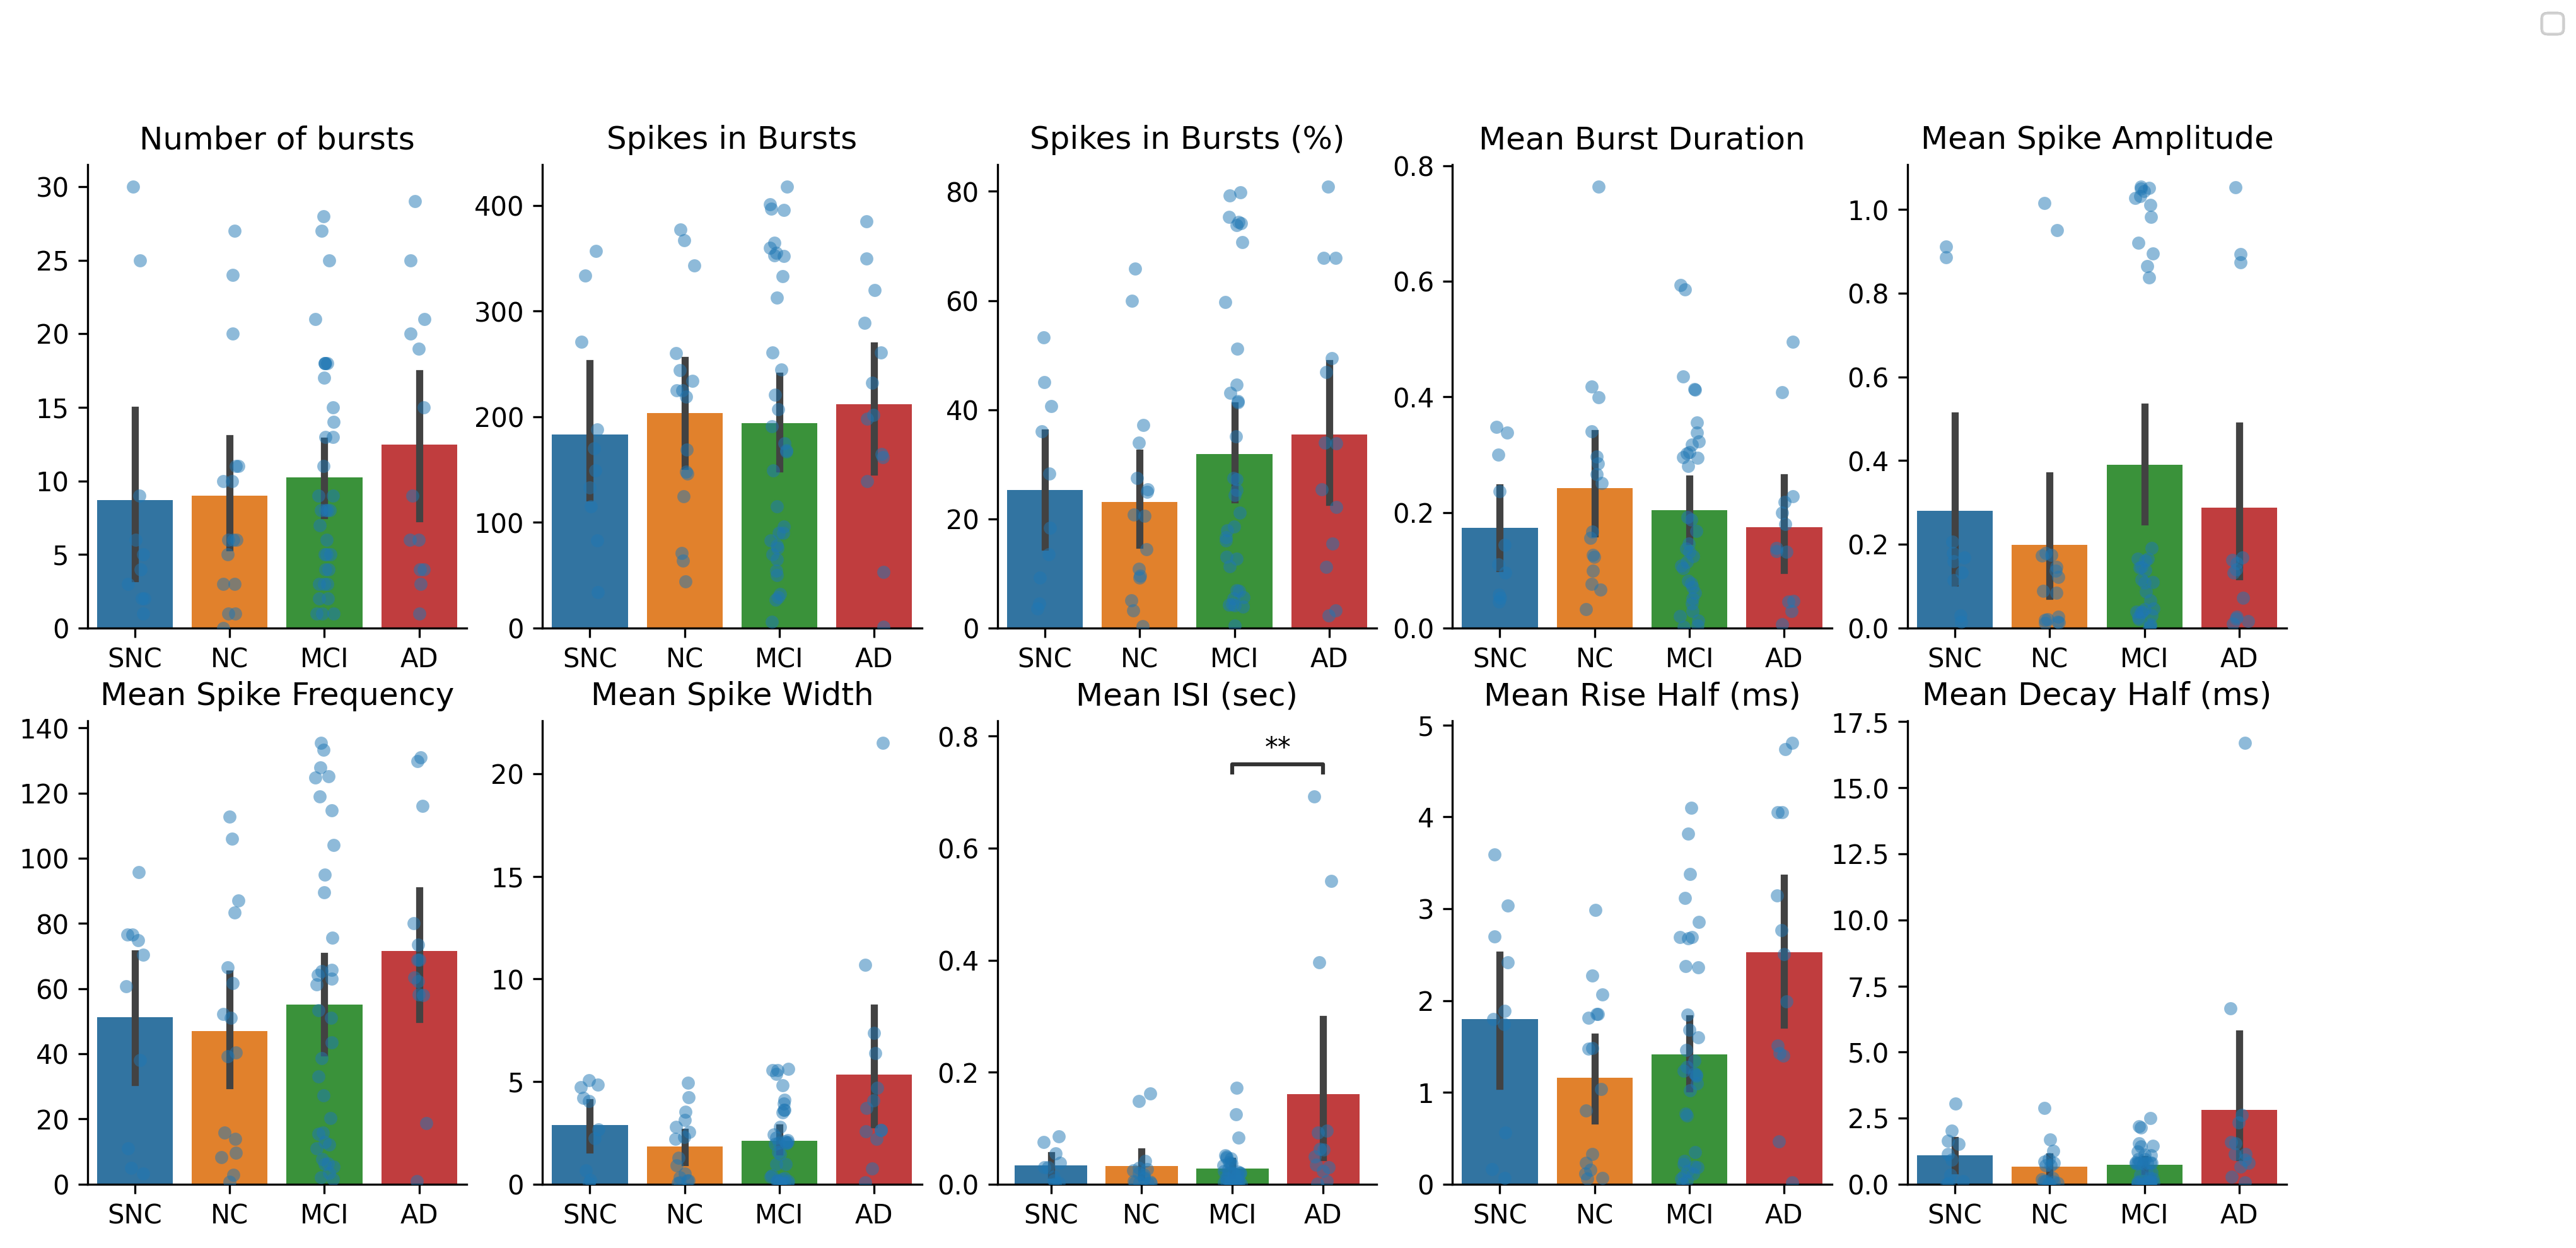

In [58]:

# plot the comparison between xi and alpha
figure = plt.figure(figsize=(15, 7), dpi=300)

# calculate the differences between xi and alpha in all columns

for i in subj_df_alpha.columns[2:12]:
    ax = figure.add_subplot(2,5, list(subj_df_alpha.columns[2:12]).index(i)+1)

    yvar = np.abs(subj_df_xi[subj_df_xi['node'].isin(['pCNG-R'])][i] - subj_df_xi[subj_df_xi['node'].isin(['pCNG-L'])][i])
    sns.barplot(x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', ])]['group'], 
                y= yvar,
                 ax=ax, errorbar='ci')
    sns.stripplot(x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L'])]['group'], 
                y=yvar, 
                 ax=ax, dodge=True, alpha=0.5, jitter=True)

    # hide top and right frame
    sns.despine(top=True, right=True)
    # sns.barplot(x='group', y=i, data=subj_df_alpha, ax=ax)
    ax.set_title(i)
    # hide ax xlabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    handles, labels = figure.gca().get_legend_handles_labels()
    figure.legend(handles[:2], labels[:2], loc='upper right')
    
    annot = Annotator(ax, [
            (("SNC"), ("NC")),(("SNC"), ("MCI")),(("SNC"), ("AD")), (("NC"), ("MCI")), (("MCI"),("AD"))],
            x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L'])]['group'],
            y=yvar)
    annot.configure(test='Mann-Whitney', text_format='star', comparisons_correction= "BH", hide_non_significant=True, correction_format="replace")
    annot.apply_and_annotate()
